In [1]:
import pandas as pd
import numpy as np
from sksurv.nonparametric import kaplan_meier_estimator as kmf
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test
import matplotlib.patches as mpatches

In [2]:
selected_cell = 'Proliferation'

In [3]:
estimation = pd.read_csv('GSE14520.Mesenchyme.csv',index_col=0)
estimation.head()

,Other,Hepatocytes,Proliferation,vSMC,Stellate cells,CAFs,Pericytes,P-value,Correlation,RMSE
Mixture,,,,,,,,,,
GSM362947,0.317488,0.564370,0.0,0.00000,0.000000,0.027042,0.091100,0,0.807009,0.722186
GSM362948,0.398708,0.444058,0.0,0.00000,0.000000,0.100680,0.056555,0,0.809021,0.613261
GSM362949,0.400777,0.476645,0.0,0.01351,0.050370,0.018136,0.040560,0,0.861145,0.542014
GSM362950,0.443174,0.407487,0.0,0.00000,0.006810,0.077935,0.064594,0,0.849685,0.530998
GSM362951,0.292158,0.575179,0.0,0.00000,0.113485,0.000000,0.019179,0,0.821149,0.711933


In [4]:
survival_data = pd.read_csv('GSE14520.Survival.csv',index_col=0)
survival_data.head()

,OS_E,OS,DFS_E,DFS
GSM,,,,
GSM363205,0,58.0,0,58.0
GSM363115,0,66.6,0,66.6
GSM362970,0,67.3,0,67.3
GSM363354,1,10.4,1,10.4
GSM363039,0,52.8,0,52.8


In [5]:
dfs_data = survival_data.filter(['DFS_E', 'DFS'])
dfs_data = dfs_data.dropna(axis=0,how='any')
binary = {1:True,0:False}
dfs_data['DFS_E'] = [binary[event] for event in dfs_data['DFS_E']]
dfs_data['DFS_T'] = [time for time in dfs_data['DFS']]
dfs_data.head()

,DFS_E,DFS,DFS_T
GSM,,,
GSM363205,False,58.0,58.0
GSM363115,False,66.6,66.6
GSM362970,False,67.3,67.3
GSM363354,True,10.4,10.4
GSM363039,False,52.8,52.8


In [6]:
survival_test = estimation.merge(dfs_data,left_index=True,right_index=True,how='inner')
survival_test.head()

,Other,Hepatocytes,Proliferation,vSMC,Stellate cells,CAFs,Pericytes,P-value,Correlation,RMSE,DFS_E,DFS,DFS_T
GSM362947,0.317488,0.564370,0.0,0.00000,0.00000,0.027042,0.091100,0,0.807009,0.722186,True,50.0,50.0
GSM362948,0.398708,0.444058,0.0,0.00000,0.00000,0.100680,0.056555,0,0.809021,0.613261,True,8.8,8.8
GSM362949,0.400777,0.476645,0.0,0.01351,0.05037,0.018136,0.040560,0,0.861145,0.542014,True,18.2,18.2
GSM362950,0.443174,0.407487,0.0,0.00000,0.00681,0.077935,0.064594,0,0.849685,0.530998,True,30.1,30.1
GSM362952,0.288244,0.638074,0.0,0.00000,0.00000,0.006728,0.066953,0,0.841236,0.758716,False,54.3,54.3


In [7]:
survival_reorder = survival_test.sort_values(selected_cell,axis=0,ascending=False)
survival_reorder.head()

,Other,Hepatocytes,Proliferation,vSMC,Stellate cells,CAFs,Pericytes,P-value,Correlation,RMSE,DFS_E,DFS,DFS_T
GSM363184,0.318450,0.094783,0.286909,0.024545,0.000000,0.275313,0.000000,0,0.012825,1.076228,False,16.3,16.3
GSM363245,0.376271,0.276135,0.248447,0.000000,0.000000,0.068444,0.030703,0,0.627975,0.778883,False,57.5,57.5
GSM362956,0.214995,0.408523,0.233337,0.000000,0.000000,0.104082,0.039063,0,0.503241,0.953495,True,13.3,13.3
GSM363271,0.384277,0.146608,0.224070,0.027240,0.000000,0.212196,0.005609,0,0.264961,0.983392,False,28.7,28.7
GSM363070,0.350195,0.358676,0.209092,0.000000,0.008677,0.057326,0.016034,0,0.644408,0.783682,False,57.0,57.0


In [8]:
running_length = len(survival_reorder)

logrank_tests = []
cut_points = []

for i in range(running_length):
    cut_point = int(i+1)
    E = list(survival_reorder['DFS_E'])
    mid_point = int(len(E)/2)
    E_high = E[:cut_point]
    E_low = E[cut_point:]
    S = list(survival_reorder['DFS_T'])
    S_high = S[:cut_point]
    S_low = S[cut_point:]
    results = logrank_test(S_high,S_low,E_high,E_low)
    p = results.p_value
    cut_points.append(cut_point)
    logrank_tests.append(p)

optimization = pd.DataFrame(logrank_tests,index=cut_points,columns=['Log Rank Test'])

In [13]:
#optimization = optimization.dropna()
#optimization = optimization.sort_values('Log Rank Test')
#optimization = int(optimization.iloc[0].name)
optimization = int(len(E)/2)

In [14]:
dfs_cut_level = survival_reorder[selected_cell][optimization]
dfs_cut_level

0.0

In [15]:
E = list(survival_reorder['DFS_E'])
cut_point = optimization
E_high = E[:cut_point]
E_low = E[cut_point:]
S = list(survival_reorder['DFS_T'])
S_high = S[:cut_point]
S_low = S[cut_point:]
results = logrank_test(S_high,S_low,E_high,E_low)
p = results.p_value
p = round(p,5)
p

0.39456

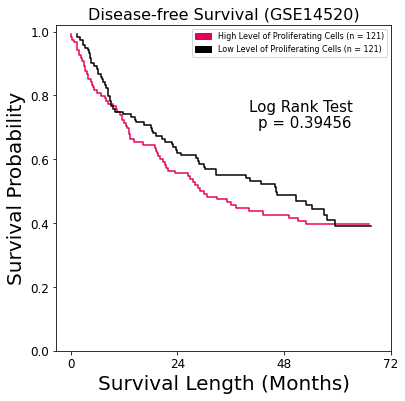

In [16]:
plt.figure(figsize=(6,6))
t,s = kmf(E_high, S_high)
plt.step(t,s,c='#e6005c')
t,s = kmf(E_low, S_low)
plt.step(t,s,c='k')
plt.xticks(np.arange(0,73,24),fontsize=12)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.xlabel('Survival Length (Months)', fontsize=20)
plt.ylabel('Survival Probability',fontsize=20)
high_patch = mpatches.Patch(color='#e6005c',label='High Level of Proliferating Cells (n = %s)'%len(E_high))
low_patch = mpatches.Patch(color='k',label='Low Level of Proliferating Cells (n = %s)'%len(E_low))
plt.text(40,0.75, 'Log Rank Test',fontsize=15)
plt.text(42,0.7, 'p = %s'%p,fontsize=15)
plt.legend(handles=[high_patch,low_patch],fontsize=8)
plt.title('Disease-free Survival (GSE14520)',fontsize=16)
plt.savefig('GSE14520.%s.DFS.pdf'%selected_cell,format='pdf')

In [17]:
os_data = survival_data.filter(['OS_E', 'OS'])
os_data = os_data.dropna(axis=0,how='any')
binary = {1:True,0:False}
os_data['OS_E'] = [binary[event] for event in os_data['OS_E']]
os_data['OS_T'] = [time for time in os_data['OS']]
os_data.head()

,OS_E,OS,OS_T
GSM,,,
GSM363205,False,58.0,58.0
GSM363115,False,66.6,66.6
GSM362970,False,67.3,67.3
GSM363354,True,10.4,10.4
GSM363039,False,52.8,52.8


In [18]:
survival_test = estimation.merge(os_data,left_index=True,right_index=True,how='inner')
survival_test.head()

,Other,Hepatocytes,Proliferation,vSMC,Stellate cells,CAFs,Pericytes,P-value,Correlation,RMSE,OS_E,OS,OS_T
GSM362947,0.317488,0.564370,0.0,0.00000,0.00000,0.027042,0.091100,0,0.807009,0.722186,True,59.2,59.2
GSM362948,0.398708,0.444058,0.0,0.00000,0.00000,0.100680,0.056555,0,0.809021,0.613261,False,61.4,61.4
GSM362949,0.400777,0.476645,0.0,0.01351,0.05037,0.018136,0.040560,0,0.861145,0.542014,True,18.2,18.2
GSM362950,0.443174,0.407487,0.0,0.00000,0.00681,0.077935,0.064594,0,0.849685,0.530998,False,57.5,57.5
GSM362952,0.288244,0.638074,0.0,0.00000,0.00000,0.006728,0.066953,0,0.841236,0.758716,False,54.3,54.3


In [19]:
survival_reorder = survival_test.sort_values(selected_cell,axis=0,ascending=False)
survival_reorder

,Other,Hepatocytes,Proliferation,vSMC,Stellate cells,CAFs,Pericytes,P-value,Correlation,RMSE,OS_E,OS,OS_T
GSM363184,0.318450,0.094783,0.286909,0.024545,0.000000,0.275313,0.000000,0,0.012825,1.076228,False,16.3,16.3
GSM363245,0.376271,0.276135,0.248447,0.000000,0.000000,0.068444,0.030703,0,0.627975,0.778883,False,57.5,57.5
GSM362956,0.214995,0.408523,0.233337,0.000000,0.000000,0.104082,0.039063,0,0.503241,0.953495,True,13.3,13.3
GSM363271,0.384277,0.146608,0.224070,0.027240,0.000000,0.212196,0.005609,0,0.264961,0.983392,False,28.7,28.7
GSM363070,0.350195,0.358676,0.209092,0.000000,0.008677,0.057326,0.016034,0,0.644408,0.783682,False,57.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM363124,0.139687,0.758574,0.000000,0.000000,0.002129,0.004540,0.095070,0,0.906032,0.827322,False,53.5,53.5
GSM363125,0.189868,0.697259,0.000000,0.000000,0.016797,0.033839,0.062237,0,0.605322,1.190969,True,16.5,16.5
GSM363126,0.181145,0.771548,0.000000,0.000000,0.008921,0.012494,0.025893,0,0.927065,0.811457,False,59.5,59.5
GSM363128,0.219605,0.731731,0.000000,0.000000,0.001598,0.011870,0.035196,0,0.850392,0.887497,True,30.1,30.1


In [20]:
running_length = len(survival_reorder)

logrank_tests = []
cut_points = []

for i in range(running_length):
    cut_point = int(i+1)
    E = list(survival_reorder['OS_E'])
    mid_point = int(len(E)/2)
    E_high = E[:cut_point]
    E_low = E[cut_point:]
    S = list(survival_reorder['OS_T'])
    S_high = S[:cut_point]
    S_low = S[cut_point:]
    results = logrank_test(S_high,S_low,E_high,E_low)
    p = results.p_value
    cut_points.append(cut_point)
    logrank_tests.append(p)

optimization = pd.DataFrame(logrank_tests,index=cut_points,columns=['Log Rank Test'])

In [25]:
#optimization = optimization.dropna()
#optimization = optimization.sort_values('Log Rank Test')
#optimization = int(optimization.iloc[0].name)
optimization = int(len(E)/2)

In [26]:
os_cut_level = survival_reorder[selected_cell][optimization]
os_cut_level

0.0

In [27]:
E = list(survival_reorder['OS_E'])
cut_point = optimization
E_high = E[:cut_point]
E_low = E[cut_point:]
S = list(survival_reorder['OS_T'])
S_high = S[:cut_point]
S_low = S[cut_point:]
results = logrank_test(S_high,S_low,E_high,E_low)
p = results.p_value
p = round(p,5)
p

0.23549

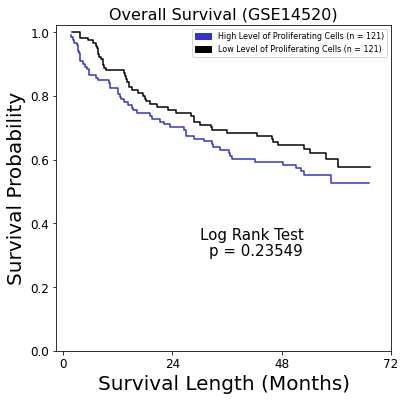

In [28]:
plt.figure(figsize=(6,6))
t,s = kmf(E_high, S_high)
plt.step(t,s,c='#3333cc')
t,s = kmf(E_low, S_low)
plt.step(t,s,c='k')
plt.xticks(np.arange(0,73,24),fontsize=12)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.xlabel('Survival Length (Months)', fontsize=20)
plt.ylabel('Survival Probability',fontsize=20)
high_patch = mpatches.Patch(color='#3333cc',label='High Level of Proliferating Cells (n = %s)'%len(E_high))
low_patch = mpatches.Patch(color='k',label='Low Level of Proliferating Cells (n = %s)'%len(E_low))
plt.text(30,0.35, 'Log Rank Test',fontsize=15)
plt.text(32,0.3, 'p = %s'%p,fontsize=15)
plt.legend(handles=[high_patch,low_patch],fontsize=8)
plt.title('Overall Survival (GSE14520)',fontsize=16)
plt.savefig('GSE14520.%s.OS.pdf'%selected_cell,format='pdf')

In [29]:
estimation = estimation.sort_values(selected_cell,ascending=False)
x = []
y = []
for key,value in enumerate(estimation[selected_cell]):
    x.append(key)
    y.append(value)

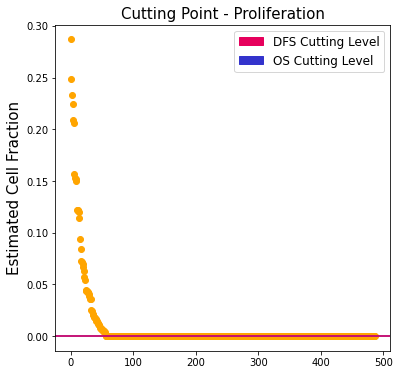

In [30]:
plt.figure(figsize=(6,6))
plt.scatter(x,y,color='orange')
plt.axhline(y=os_cut_level, xmin=0, xmax=100,color='#3333cc')
plt.axhline(y=dfs_cut_level, xmin=0, xmax=100,color='#e6005c')
plt.ylabel('Estimated Cell Fraction',fontsize=15)
plt.title('Cutting Point - %s'%selected_cell,fontsize=15)
dfs_patch = mpatches.Patch(color='#e6005c',label='DFS Cutting Level')
os_patch = mpatches.Patch(color='#3333cc',label='OS Cutting Level')
plt.legend(handles=[dfs_patch,os_patch],fontsize=12)
plt.savefig('Cutting_Point.%s'%selected_cell,format='pdf')